### InterRater Evaluation Pipeline

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.journal_run.model_load.load_ssn import load_ssn
from trustworthai.journal_run.model_load.load_punet import load_p_unet
from trustworthai.journal_run.model_load.load_deterministic import load_deterministic
from trustworthai.journal_run.model_load.load_evidential import load_evidential
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch


import numpy as np
from tqdm import tqdm
import scipy.stats
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

import pandas as pd
from trustworthai.analysis.connected_components.connected_comps_2d import conn_comp_2d_analysis
from trustworthai.analysis.evaluation_metrics.challenge_metrics import getAVD, getDSC, getHausdorff, getLesionDetection, do_challenge_metrics
from sklearn import metrics
import math

import torch
import matplotlib.pyplot as plt
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write
from trustworthai.analysis.calibration.helper_funcs import *
from tqdm import tqdm
from trustworthai.utils.logits_to_preds import normalize_samples

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples


# evaluation code
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *
from trustworthai.journal_run.evaluation.new_scripts.model_predictions import *
from trustworthai.analysis.connected_components.connected_comps_2d import *
print("banana")


strawberry
banana


In [233]:
import matplotlib.pyplot as plt
# import proplot
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples

In [3]:
%load_ext autoreload

In [4]:
import seaborn as sns

In [5]:
from twaidata.torchdatasets.DirectoryParser3DMRIDataset import *

In [6]:
VOXELS_TO_WMH_RATIO = 382
VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES = 140

In [49]:
class ARGS():
    def __init__(self):
    
        # folder arguments
        self.ckpt_dir = '/home/s2208943/ipdis/results/journal_models/cross_validated_models/'
        self.model_name = "ssn_ens0_cv0"
        self.model_ckpts_folder = "/home/s2208943/ipdis/results/journal_models/cross_validated_models/" # "/home/s2208943/ipdis/results/cross_validated_models/"
        self.repo_dir = "/home/s2208943/ipdis/WMH_UQ_assessment"
        self.result_dir = "trustworthai/journal_run/interrater_experiments/results/"
        self.model_type = "ssn"
        self.uncertainty_type = "ssn"
        
        # data generation arguments
        self.dataset = 'chal'
        self.seed = 3407
        self.test_split = 0.15
        self.val_split = 0.15
        self.empty_slice_retention = 0.1
        
        # general arguments for the loss function
        self.loss_name = 'dice+xent'#'dicev2'#'dice+xent'
        self.dice_factor = 1#5
        self.xent_factor = 1#0.01
        self.xent_weight = 'none'
        self.xent_reweighting=1
        self.dice_empty_slice_weight = 0.5
        self.tversky_beta = 0.7
        self.reduction = 'mean'#'mean_sum'
        
        # evidential arguments
        self.kl_factor=0.1
        self.kl_anneal_count=452*4
        self.use_mle=0
        self.analytic_kl=0

        # p-unet arguments
        self.kl_beta=10.
        self.use_prior_for_dice="false"
        self.punet_sample_dice_coeff=0.05
        self.latent_dim=12

        # ssn arguments
        self.ssn_rank=25
        self.ssn_epsilon=1e-5
        self.ssn_mc_samples=10
        self.ssn_sample_dice_coeff=0.05
        self.ssn_pre_head_layers=32
        
        # training paradigm arguments
        self.lr = 2e-4
        self.dropout_p = 0.1
        self.encoder_dropout1 = 0
        self.encoder_dropout2 = 0
        self.decoder_dropout1 = 0
        self.decoder_dropout2 = 0
        self.max_epochs = 100
        self.early_stop_patience = 15
        self.batch_size = 8#32
        self.cross_validate = "true"
        self.cv_split = 0
        self.cv_test_fold_smooth = 1
        self.weight_decay = 0.0001
        self.overwrite = "true"
        self.no_test_fold = 'false'

In [50]:
args = ARGS()

# sanitise arguments
args.overwrite = True if args.overwrite.lower() == "true" else False
args.cross_validate = True if args.cross_validate.lower() == "true" else False
args.use_prior_for_dice = True if args.use_prior_for_dice.lower() == "true" else False
print(f"CHECKPOINT DIR: {args.ckpt_dir}")
#print(args)


# check if folder exists
model_result_folder = os.path.join(args.repo_dir, args.result_dir)
if not args.overwrite:
    existing_files = os.listdir(model_result_folder)
    for f in existing_files:
        if args.model_name + "_" in f:
            raise ValueError(f"ovewrite = false and model results exist! folder={model_result_folder}, model_name={args.model_name}")
with open(os.path.join(model_result_folder, f"{args.model_name}_init.txt"), "w") as f:
                      f.write("generating results\n")
        
# setup xent reweighting factor
XENT_VOXEL_RESCALE = VOXELS_TO_WMH_RATIO - (1-args.empty_slice_retention) * (VOXELS_TO_WMH_RATIO - VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES)

XENT_WEIGHTING = XENT_VOXEL_RESCALE/2
args.xent_reweighting = XENT_WEIGHTING

CHECKPOINT DIR: /home/s2208943/ipdis/results/journal_models/cross_validated_models/


In [51]:
%autoreload

In [52]:
MODEL_LOADERS = {
    "deterministic":load_deterministic,
    "mc_drop":load_deterministic,
    "evidential":load_evidential,
    "ssn":load_ssn,
    "punet":load_p_unet,
}

MODEL_OUTPUT_GENERATORS = {
    "deterministic":mc_drop_mean_and_samples,
    "mc_drop":mc_drop_mean_and_samples,
    "evidential":evid_mean,
    "ssn":ssn_mean_and_samples,
    "punet":punet_mean_and_samples,
    "ind":ssn_mean_and_samples,
    "ens":ensemble_mean_and_samples,
    "ssn_ens":ssn_ensemble_mean_and_samples,
}

### setting up model and data

In [53]:
# get the 3d dataloader
mss3_ds = MSS3InterRaterDataset()


In [54]:
len(mss3_ds)

68

In [55]:
xs, ys, ind = mss3_ds[10]

In [56]:
ind

'MSS3_ED_003_V1'

In [57]:
xs.keys(), ys.keys()

(dict_keys(['mask', 'FLAIR', 'T1']), dict_keys(['lacune', 'wmhes', 'wmhmvh']))

In [58]:
xs['mask'].shape

torch.Size([53, 240, 240])

In [59]:
import matplotlib.pyplot as plt

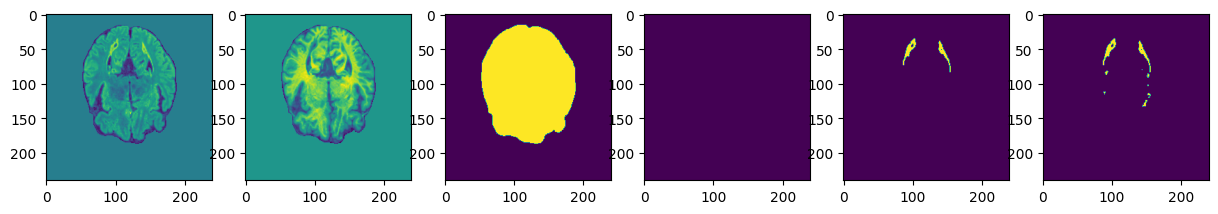

In [60]:
plt.figure(figsize=(15, 8))
plt.subplot(1,6,1)
plt.imshow(xs['FLAIR'][23])
plt.subplot(1,6,2)
plt.imshow(xs['T1'][23])
plt.subplot(1,6,3)
plt.imshow(xs['mask'][23])
plt.subplot(1,6,4)
plt.imshow(ys['lacune'][23])
plt.subplot(1,6,5)
plt.imshow(ys['wmhes'][23])
plt.subplot(1,6,6)
plt.imshow(ys['wmhmvh'][23])

In [61]:
uncertainty_thresholds = torch.arange(0, 0.7, 0.01)

In [62]:
# load the model
model_dir = os.path.join(args.ckpt_dir, args.model_name)  
print("model dir: ", model_dir)
model_raw, loss, val_loss = MODEL_LOADERS[args.model_type](args)
model = load_best_checkpoint(model_raw, loss, model_dir, punet=args.model_type == "punet")

model dir:  /home/s2208943/ipdis/results/journal_models/cross_validated_models/ssn_ens0_cv0


### collecting basic results

set of results to collect:

- [ ] best dice per rater
- [ ] best AVD per rater
- [ ] GeD
- [ ] UIRO
- [ ] JUEO
- [ ] IR_RMBS
- [ ] connected component analysis. If we can do all these things then we are done!


In [67]:
xs3d_test = []
ys3d_test = []

for (xs, ys, ind) in tqdm(mss3_ds):
    if "wmhes" in ys.keys() and "wmhmvh" in ys.keys():
        xs3d_test.append(torch.stack([xs['FLAIR'], xs['mask'], xs['T1']], dim=0))
        ys3d_test.append(torch.stack([ys['wmhes'], ys['wmhmvh']], dim=0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:10<00:00,  6.35it/s]


In [71]:
rater0 = [y[0] for y in ys3d_test]
rater1 = [y[1] for y in ys3d_test]

In [91]:
rater_union = [y[0] * y[1] for y in ys3d_test]

In [85]:
rater0_ds = list(zip(xs3d_test, rater0))

In [97]:
from collections import defaultdict

In [86]:
gt_vols = [(torch.sum(y[0]), torch.sum(y[1])) for y in ys3d_test]

In [376]:
mean_gt_vols = [(torch.sum(y[0]) + torch.sum(y[1]))/2 for y in ys3d_test]

In [320]:
raters = [rater0, rater1]
rater_results = [defaultdict(lambda : {}) for _ in range(len(raters))]
overall_results = defaultdict(lambda: {})

print("loading model predictions")
means, samples_all, misc = get_means_and_samples(model_raw, rater0_ds, num_samples=30, model_func=MODEL_OUTPUT_GENERATORS[args.uncertainty_type], args=args)

for num_samples in [2, 3, 5, 7, 10, 15, 20, 25, 30]:
    print("NUM SAMPLES: ", num_samples)
    args.eval_sample_num = num_samples
    try:
        # load the predictions
        print("extracting sample subset")
        print(args.uncertainty_type)
        samples = [s[:num_samples] for s in tqdm(samples_all)]

        # run the evaluation on the samples
        print("GETTING PER SAMPLE RESULTS")
        if samples[0] is not None:
            samples = [reorder_samples(s) for s in samples]
            for r, rater in enumerate(raters):
                sample_top_dices, sample_dices = per_sample_metric(samples, rater, f=fast_dice, do_argmax=True, do_softmax=False, minimise=False)
                sample_best_avds, sample_avds = per_sample_metric(samples, rater, f=fast_avd, do_argmax=True, do_softmax=False, minimise=True)
                # sample_best_rmses, sample_rmses = per_sample_metric(samples, ys3d_test, f=fast_rmse, do_argmax=False, do_softmax=True, minimise=True)
                
                rater_results[r][num_samples]['sample_top_dice'] = sample_top_dices
                rater_results[r][num_samples]['sample_best_avd'] = sample_best_avds
                
            # ged by volume
            print("COMPUTING GED BY VOLUME")
            overall_results[num_samples]['GED_vol_sorted'] = multirater_iou_GED(means, raters, samples)
                
                # break
                # best dice when sorting the sample for dice
            print("best dice and GED results sorted by dice")
            overall_results[num_samples]['GED_dice_sorted'] = []
            for r, rater in enumerate(raters):
                best_dice = []
                for i, s in tqdm(enumerate(samples)):                
                    y = rater[i].cuda()
                    s = reorder_samples_by_dice(s, y)
                    best_dice.append(fast_dice(s[-1].cuda().argmax(dim=1), y))
                    rater_results[r][num_samples][f'best_dice_dsorted_ss{num_samples}'] = best_dice

                # ged score by dice
                overall_results[num_samples]['GED_dice_sorted'].append(individual_multirater_iou_GED(means[i], [r[i] for r in raters], s))
                
            # TODO I SHOULD DO GED BASED ON DICE sorting AND VOLUME sorting
        else:
            print("samples is None, breaking now")
            break

    #         # get the uncertainty maps
    #         print("GENREATING UNCERTAINTY MAPS")
    #         uncertainty_thresholds = torch.arange(0, 0.7, 0.01)
    #         ent_maps = get_uncertainty_maps(means, samples, misc, args)

    #         # sUEO score and UEO per threshold
    #         print("UEO")
    #         sUEOs = get_sUEOs(means, ys3d_test, ent_maps)
    #         chal_results[f'sUEO_ss{num_samples}'] = sUEOs
    except Exception as e:
        print(f"failed at {num_samples}")
        print(e)
        raise e
        break

# # save the results
# print("SAVING RESULTS")
# write_per_model_channel_stats(preds=None, ys3d_test=None, args=args, chal_results=chal_results)

# print("DONE")

loading model predictions


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:34<00:00,  1.91it/s]


NUM SAMPLES:  2
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 158.07it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 58.09it/s]


best dice and GED results sorted by dice


65it [00:01, 45.81it/s]
65it [00:01, 46.12it/s]


NUM SAMPLES:  3
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 102.17it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 37.64it/s]


best dice and GED results sorted by dice


65it [00:06, 10.10it/s]
65it [00:05, 10.95it/s]


NUM SAMPLES:  5
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 66.25it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 21.66it/s]


best dice and GED results sorted by dice


65it [00:09,  7.18it/s]
65it [00:10,  6.31it/s]


NUM SAMPLES:  7
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 53.59it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 15.46it/s]


best dice and GED results sorted by dice


65it [00:10,  6.02it/s]
65it [00:13,  4.90it/s]


NUM SAMPLES:  10
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 38.39it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:06<00:00,  9.35it/s]


best dice and GED results sorted by dice


65it [00:13,  4.94it/s]
65it [00:14,  4.37it/s]


NUM SAMPLES:  15
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 20.96it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:13<00:00,  4.82it/s]


best dice and GED results sorted by dice


65it [00:14,  4.36it/s]
65it [00:17,  3.79it/s]


NUM SAMPLES:  20
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 19.61it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:21<00:00,  3.00it/s]


best dice and GED results sorted by dice


65it [00:17,  3.79it/s]
65it [00:21,  3.03it/s]


NUM SAMPLES:  25
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 14.96it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:32<00:00,  1.98it/s]


best dice and GED results sorted by dice


65it [00:43,  1.48it/s]
65it [00:43,  1.50it/s]


NUM SAMPLES:  30
GENERATING PREDICTIONS
ssn
GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:05<00:00, 11.87it/s]


COMPUTING GED BY VOLUME


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:47<00:00,  1.38it/s]


best dice and GED results sorted by dice


65it [00:52,  1.23it/s]
65it [00:50,  1.28it/s]


In [107]:
# rater_results

In [321]:
mean_results = [
    {n_samples:
         {key: torch.Tensor(values).mean()
          for (key, values) in value_map.items() 
         }
     for (n_samples, value_map) in results_map.items()
    }
    for results_map in rater_results
]

In [322]:
num_samples = [2, 3, 5, 7, 10, 15, 20, 25, 30]

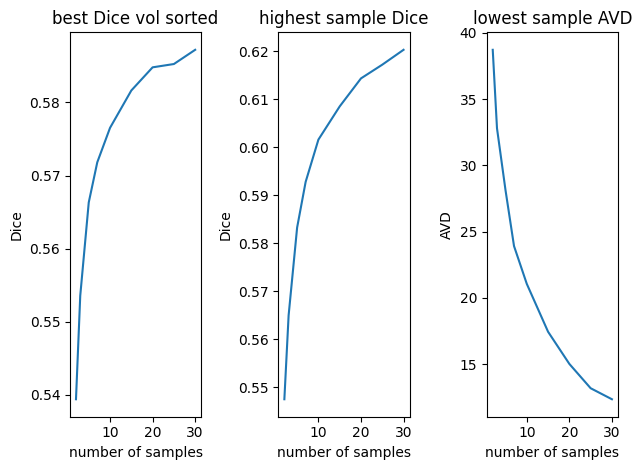

In [324]:
num_samples = [2, 3, 5, 7, 10, 15, 20, 25, 30]
plt.subplot(1, 3, 1)
plt.plot(num_samples, [mean_results[0][ns]['sample_top_dice'] for ns in num_samples])
plt.title("best Dice vol sorted")
plt.xlabel("number of samples")
plt.ylabel("Dice")
plt.subplot(1, 3, 2)
plt.plot(num_samples, [mean_results[0][ns][f'best_dice_dsorted_ss{ns}'] for ns in num_samples])
plt.title("highest sample Dice")
plt.ylabel("Dice")
plt.xlabel("number of samples")
plt.subplot(1, 3, 3)
plt.plot(num_samples, [mean_results[0][ns]['sample_best_avd'] for ns in num_samples])
plt.title("lowest sample AVD")
plt.ylabel("AVD")
plt.xlabel("number of samples")
plt.tight_layout()

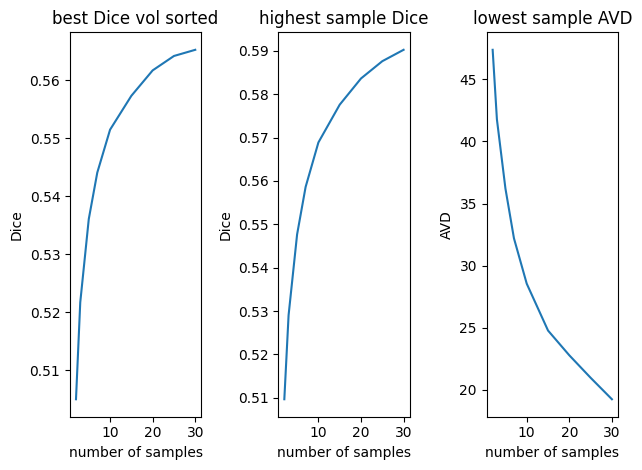

In [325]:
num_samples = [2, 3, 5, 7, 10, 15, 20, 25, 30]
plt.subplot(1, 3, 1)
plt.plot(num_samples, [mean_results[1][ns]['sample_top_dice'] for ns in num_samples])
plt.title("best Dice vol sorted")
plt.xlabel("number of samples")
plt.ylabel("Dice")
plt.subplot(1, 3, 2)
plt.plot(num_samples, [mean_results[1][ns][f'best_dice_dsorted_ss{ns}'] for ns in num_samples])
plt.title("highest sample Dice")
plt.ylabel("Dice")
plt.xlabel("number of samples")
plt.subplot(1, 3, 3)
plt.plot(num_samples, [mean_results[1][ns]['sample_best_avd'] for ns in num_samples])
plt.title("lowest sample AVD")
plt.ylabel("AVD")
plt.xlabel("number of samples")
plt.tight_layout()

In [336]:
mean_ged_results = {n_samples:
         {key: torch.Tensor(values).mean()
          for (key, values) in value_map.items() 
         }
     for (n_samples, value_map) in overall_results.items()
}


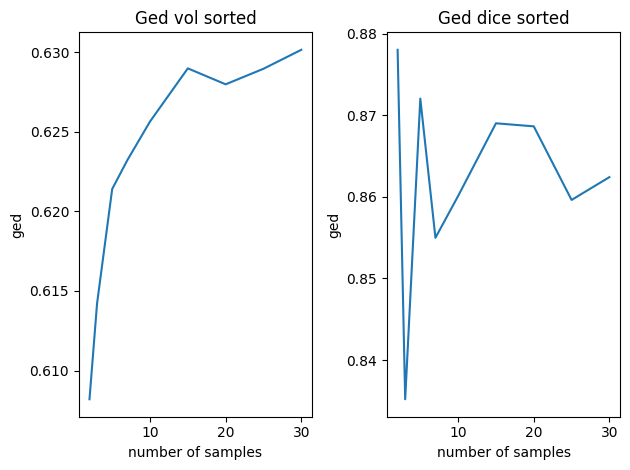

In [337]:
num_samples = [2, 3, 5, 7, 10, 15, 20, 25, 30]
plt.subplot(1, 2, 1)
plt.plot(num_samples, [mean_ged_results[ns]['GED_vol_sorted'] for ns in num_samples])
plt.title("Ged vol sorted")
plt.xlabel("number of samples")
plt.ylabel("ged")
plt.subplot(1, 2, 2)
plt.plot(num_samples, [mean_ged_results[ns][f'GED_dice_sorted'] for ns in num_samples])
plt.title("Ged dice sorted")
plt.ylabel("ged")
plt.xlabel("number of samples")
plt.tight_layout()

### developing UIRO and JUEO

UIRO is the overlap between the uncertainty - actual errors and the area where the raters overlap
JUEO is the overlap between the uncertainty minus the IR disagreement areas and the areas where the model is wrong and both annotators agree



In [326]:
raters = [rater0, rater1]
rater_results = [defaultdict(lambda : {}) for _ in range(len(raters))]

num_samples_list = [2, 3, 5, 7, 10, 15, 20, 25, 30]
num_samples = 30
print("NUM SAMPLES: ", num_samples)
args.eval_sample_num = num_samples

# load the predictions
print("GENERATING PREDICTIONS")
print(args.uncertainty_type)
means, samples, misc = get_means_and_samples(model_raw, rater0_ds, num_samples=num_samples, model_func=MODEL_OUTPUT_GENERATORS[args.uncertainty_type], args=args)

uncertainty_thresholds = torch.arange(0, 0.7, 0.01)
ent_maps = get_uncertainty_maps(means, samples, misc, args)

NUM SAMPLES:  30
GENERATING PREDICTIONS
ssn


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:41<00:00,  1.56it/s]


ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:08<00:00,  8.01it/s]


In [327]:
def UIRO(pred, thresholded_umap, seg1, seg2):
    IR = (seg1 != seg2)
    error = (seg1 == seg2) * (seg1 != pred)
    thresholded_umap[error] = 0
    return fast_dice(thresholded_umap, IR)


def JUEO(pred, thresholded_umap, seg1, seg2):
    IR = (seg1 != seg2)
    error = (seg1 == seg2) * (seg1 != pred)
    thresholded_umap[IR] = 0
    return fast_dice(thresholded_umap, error)

def per_rater_UEO(pred, thresholded_umap, seg1, seg2):
    error1 = (seg1 != pred)
    error2 = (seg2 != pred)
    
    return fast_dice(thresholded_umap, error1), fast_dice(thresholded_umap, error2)

In [328]:
idx = 1
print((rater0[idx] != rater1[idx]).sum())
print((rater0[idx] == rater1[idx]).sum())
print((means[idx].argmax(dim=1) == rater0[idx]).sum())
print((means[idx].argmax(dim=1) != rater0[idx]).sum())
print(((means[idx].argmax(dim=1) != rater0[idx]) * (rater0[idx] == rater1[idx])).sum())
print(fast_dice(ent_maps[idx] > 0.4, (means[idx].argmax(dim=1) != rater0[idx]) * (rater0[idx] == rater1[idx])))

tensor(1207)
tensor(3051593)
tensor(3051125)
tensor(1675)
tensor(1426)
0.33820033073425293


In [329]:
def per_threshold_ueos():
    uiro_curves = []
    jueo_curves = []
    for i in tqdm(range(len(xs3d_test))):
        uiro = []
        jueo = []
        m = means[i].argmax(dim=1).cuda()
        for t in uncertainty_thresholds:
            e = ent_maps[i] > t
            e = e.cuda()
            uiro.append(UIRO(m, e.clone(), rater0[i].cuda(), rater1[i].cuda()))
            jueo.append(JUEO(m, e.clone(), rater0[i].cuda(), rater1[i].cuda()))
        uiro_curves.append(uiro)
        jueo_curves.append(jueo)
        
    return uiro_curves, jueo_curves

In [330]:
uiro_curves, jueo_curves = per_threshold_ueos()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:47<00:00,  1.36it/s]


In [331]:
import matplotlib.cm as cm 

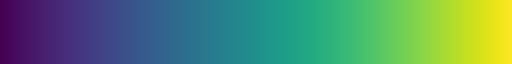

In [332]:
cm.viridis

In [333]:
max_vol = torch.Tensor(gt_vols)[:,0].max()
max_vol

tensor(18482.)

Text(0, 0.5, 'UIRO')

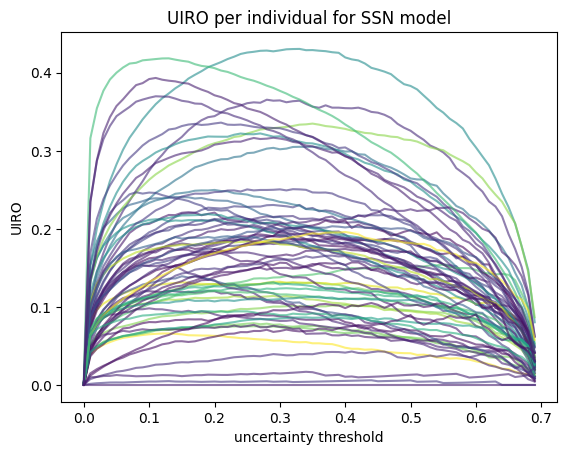

In [334]:
for i, curve in enumerate(uiro_curves):
    plt.plot(uncertainty_thresholds, curve, color=cm.viridis(gt_vols[i][0] / 18482), alpha=0.6)
plt.title("UIRO per individual for SSN model")
plt.xlabel("uncertainty threshold")
plt.ylabel("UIRO")

In [339]:
torch.Tensor(uiro_curves).mean(dim=1)

tensor([0.2916, 0.1865, 0.1525, 0.1679, 0.0471, 0.0598, 0.0612, 0.1069, 0.0858,
        0.0936, 0.2452, 0.1781, 0.1923, 0.1271, 0.1516, 0.1168, 0.1543, 0.3506,
        0.1594, 0.0685, 0.2797, 0.1217, 0.0606, 0.1271, 0.1490, 0.0847, 0.1498,
        0.1467, 0.2571, 0.1710, 0.1046, 0.0871, 0.2646, 0.2001, 0.1504, 0.1670,
        0.1164, 0.1732, 0.0893, 0.1752, 0.1227, 0.1639, 0.1017, 0.1361, 0.1600,
        0.1693, 0.1462, 0.0689, 0.1291, 0.1570, 0.0975, 0.0037, 0.0000, 0.1563,
        0.0734, 0.1074, 0.0773, 0.0323, 0.0808, 0.3144, 0.2475, 0.0633, 0.2606,
        0.2808, 0.0122])

In [342]:
means[-13].argmax(dim=1).sum()

tensor(571)

### note maria's comment

she states that the differences between raters are really around whether lesions should exist or not, whether they have been missed by the machine, not whether the boundary is correct. So we expect the UIRO to be low because there is likely a lot of boundary in this case.
So the question is, is that true, if we block out the boundary then what do we find? That would be an interesting question to ask I think. So we think that the result above is explainable and makes sense :)


Also note to self: think about using median and IQR due to the outliers in UIRO and JUEO when comparing methods.

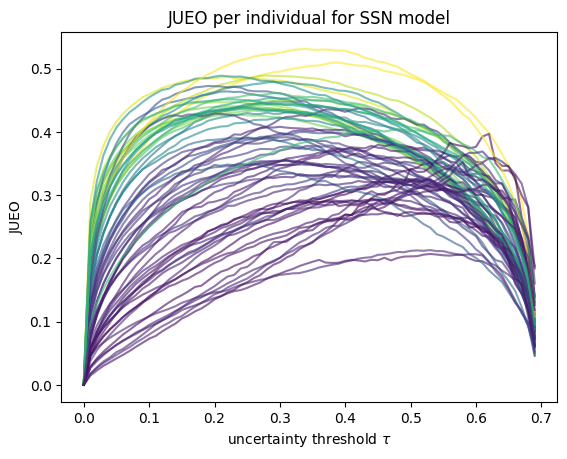

In [335]:
for i, curve in enumerate(jueo_curves):
    plt.plot(uncertainty_thresholds, curve, color=cm.viridis(gt_vols[i][0] / 18482), alpha=0.6)
    plt.title("JUEO per individual for SSN model")
    plt.xlabel(r"uncertainty threshold $\tau$")
    plt.ylabel("JUEO")

### RMBS over the image and in the IR areas

In [405]:
def get_2rater_rmse(pred, y0, y1, p=0.1):
    label = torch.zeros(pred.shape, device='cuda')
    label[:,0] = (y0 == 0) & (y1 == 0)
    label[:,1] = (y0 == 1) & (y1 == 1)
    diff = (y0 != y1)
    label[:,0][diff] = 0.5
    label[:, 1][diff] = 0.5
    
    locs = pred[:,1] > p
    # print(pred.shape)
    
    pred = pred.moveaxis(1, -1)[locs]
    label = label.moveaxis(1, -1)[locs]
    
    rmse = ((pred - label).square().sum(dim=1) / pred.shape[1]).mean().sqrt()

    return rmse.item()

def get_IR_rmse(pred, y0, y1, p=0.1):
    label = torch.zeros(pred.shape, device='cuda')
    label[:,0] = (y0 == 0) & (y1 == 0)
    label[:,1] = (y0 == 1) & (y1 == 1)
    diff = (y0 != y1)
    label[:,0][diff] = 0.5
    label[:, 1][diff] = 0.5
    
    locs = diff
    # print(pred.shape)
    
    pred = pred.moveaxis(1, -1)[locs]
    label = label.moveaxis(1, -1)[locs]
    
    rmse = ((pred - label).square().sum(dim=1) / pred.shape[1]).mean().sqrt()

    return rmse.item()

rmses = []
IR_rmses = []
p = 0.1
for i in tqdm(range(len(means))):
    y0 = rater0[i]
    y1 = rater1[i]
    m = means[i].cuda()
    m = m.softmax(dim=1)
    rmse = get_2rater_rmse(m, y0, y1, p)
    ir_rmse = get_IR_rmse(m, y0, y1, p)
    
    rmses.append(rmse)
    IR_rmses.append(ir_rmse)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 29.42it/s]


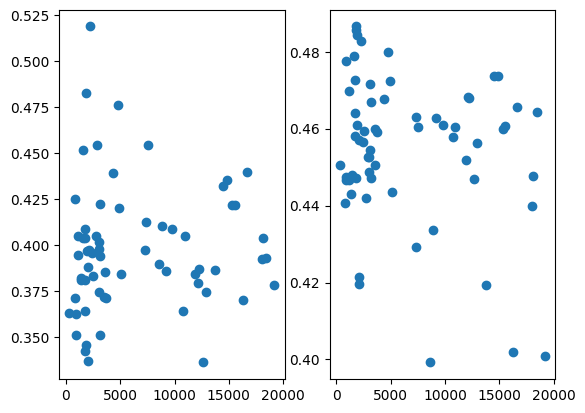

In [406]:
plt.subplot(1,2,1)
plt.scatter(mean_gt_vols, rmses)
plt.subplot(1,2,2)
plt.scatter(mean_gt_vols, IR_rmses)

### UIRO and JUEO minus the edge areas because edge areas are in general uncertain. Perhaps just do this for the UIRO metric. Nice.

In [426]:
import torch
import torch.nn.functional as F

def dilate(tensor, kernel_size=3, iterations=1):
    """
    Dilate a 3D binary tensor using a cubic kernel.
    
    Parameters:
    - tensor: A 3D binary tensor of shape (C, H, W, D) where C is the channel (1 for binary images).
    - kernel_size: Size of the cubic kernel for dilation.
    - iterations: Number of times dilation is applied.
    
    Returns:
    - Dilated tensor.
    """
    padding = kernel_size // 2
    kernel = torch.ones((1, 1, kernel_size, kernel_size, kernel_size), device=tensor.device)
    for _ in range(iterations):
        tensor = F.conv3d(tensor, kernel, padding=padding, groups=1)
    return torch.clamp(tensor, 0, 1)

def erode(tensor, kernel_size=3, iterations=1):
    """
    Erode a 3D binary tensor using a cubic kernel.
    
    Parameters:
    - tensor: A 3D binary tensor of shape (C, H, W, D).
    - kernel_size: Size of the cubic kernel for erosion.
    - iterations: Number of times erosion is applied.
    
    Returns:
    - Eroded tensor.
    """
    padding = kernel_size // 2
    kernel = torch.ones((1, 1, kernel_size, kernel_size, kernel_size), device=tensor.device)
    for _ in range(iterations):
        tensor = F.conv3d(1 - tensor, kernel, padding=padding, groups=1)
    return 1 - torch.clamp(tensor, 0, 1)

def find_edges(tensor, kernel_size=3):
    """
    Find the inner and outer edges of a segmentation in a 3D binary tensor.
    
    Parameters:
    - tensor: A 3D binary tensor of shape (C, H, W, D).
    - kernel_size: Size of the cubic kernel for dilation and erosion.
    
    Returns:
    - inner_edges: The inner edges of the segmentation.
    - outer_edges: The outer edges of the segmentation.
    """
    dilated = dilate(tensor, kernel_size)
    eroded = erode(tensor, kernel_size)
    outer_edges = dilated - tensor
    inner_edges = tensor - eroded
    return inner_edges, outer_edges


In [431]:
m = means[idx].argmax(dim=1).type(torch.float32)
ies, oes = find_edges(m.unsqueeze(0))
ies = ies.squeeze()
oes = oes.squeeze()

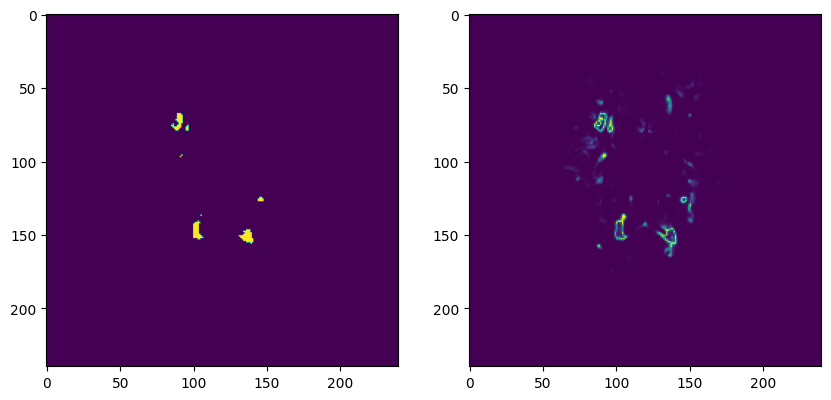

In [432]:
plt.figure(figsize=(10, 5))
idx = 1
islice = 29
plt.subplot(1,2,1)
plt.imshow(means[idx].argmax(dim=1)[islice])
plt.subplot(1,2,2)
plt.imshow(ent_maps[idx][islice])

In [441]:
ies.shape, ent_maps[idx].shape

(torch.Size([53, 240, 240]), torch.Size([53, 240, 240]))

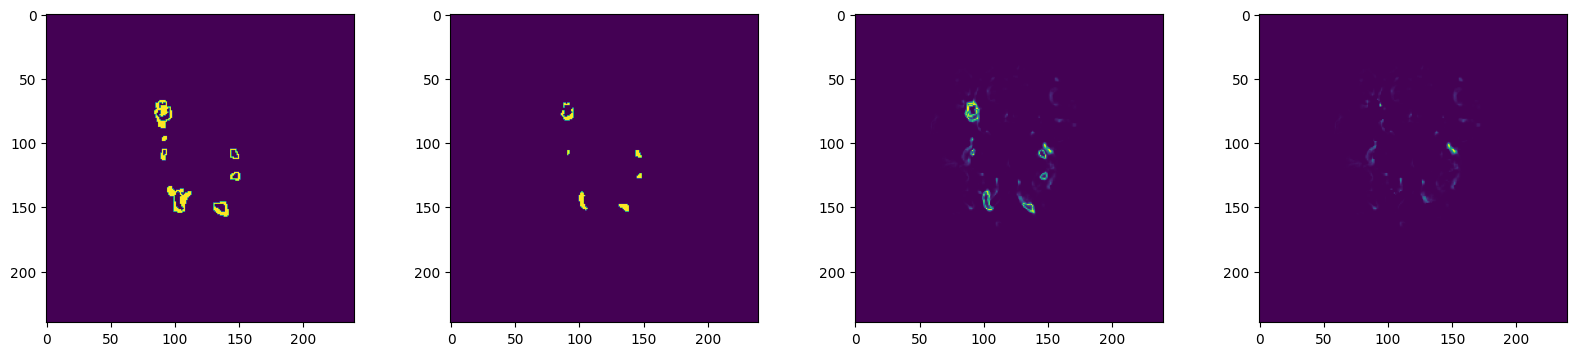

In [461]:
islice = 28
plt.figure(figsize=(20, 4))
plt.subplot(1,4,1)
plt.imshow(oes[islice])
plt.subplot(1,4,2)
plt.imshow(ies[islice])
plt.subplot(1,4,3)
e = ent_maps[idx]
v1 = e[islice].clone()
# v1 = v1 * (1- oes[islice])
v2 = e[islice].clone()
v2 = v2 * (1- ies[islice]) * (1- oes[islice])
plt.imshow(v1)
plt.subplot(1, 4, 4)
plt.imshow(v2)

In [ ]:
### so to compute our metric, we remove the inner edge and the outer edge (except where it is in a place of interest, i.e joint error, or IR difference? but then there is no way of knowing, so we should just remove the edges blidhly I think....

In [446]:
torch.where(oes[islice])

(tensor([ 67,  67,  67,  67,  67,  68,  68,  68,  68,  69,  69,  69,  70,  70,
          70,  71,  71,  71,  72,  72,  72,  72,  72,  73,  73,  73,  73,  73,
          73,  74,  74,  74,  74,  74,  74,  74,  74,  74,  75,  75,  75,  75,
          75,  75,  75,  75,  75,  75,  75,  76,  76,  76,  76,  76,  76,  76,
          76,  77,  77,  77,  77,  77,  77,  78,  78,  78,  78,  78,  78,  78,
          79,  79,  79,  79,  79,  79,  79,  79,  79,  80,  80,  80,  80,  80,
          80,  80,  80,  80,  80,  80,  80,  81,  81,  81,  81,  81,  81,  81,
          81,  81,  81,  82,  82,  82,  82,  82,  82,  82,  82,  82,  83,  83,
          83,  83,  83,  83,  95,  95,  95,  96,  96,  96,  97,  97,  97,  98,
          98,  98, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106,
         106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107,
         107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
         108, 108, 109, 109, 109, 109, 109, 109, 109

### sUIRO and sJUEO (and sUIRO without the edges included if that proves useful)

### Connected component analysis

calibration of region around missed lesions? (per lesion calibration?)
proportion of a missed lesion that is uncertain like I have done before
proportion of incorrectly added lesions that are wholly uncertain / partially uncertain

### JPT, JFP, JFN, IR
pixel wise analysis

In [197]:
idx = 2
t = 0.4
UIRO(means[idx].argmax(dim=1), ent_maps[idx] > t, rater0[idx], rater1[idx])

0.19014693796634674

In [203]:
JUEO(means[idx].argmax(dim=1), ent_maps[idx] > t, rater0[idx], rater1[idx])

0.37308868765830994

In [199]:
per_rater_UEO(means[idx].argmax(dim=1), ent_maps[idx] > t, rater0[idx], rater1[idx])

(0.36519747972488403, 0.3323558270931244)

In [153]:
means[0].shape

torch.Size([53, 2, 240, 240])

### things to compute

- [ ] developing pixel wise RMBS for the predictions, where disagreements have probability 0.5
- [ ] developing pixelwise RMBS for the inter-rater disagreement sections (p would be 0.5 for all of them) 
- [ ] and uncertainty distributions (so JTP, JFP, JTP, IR)
- [ ] GeD for multiple raters
- [ ] the plots that I computed that I put in this paper for the in-house dataset for all these datasets. (so see what happens as the number of samples increases).
- [ ] get an extension for MC-Dropout trained (6 models, same parameters, different layer combinations, along with higher dropout ratio? see what happens
- [ ] do analysis on connected components that are fully uncertain. Check the proportion of missed lesions that are fully uncertain
- [ ] do analysis where we remove uncertainty around edges?
- [ ] try soft joint uncertainty error overlap per component.



### examining outlier individuals

In [261]:
### low volume very high percentage volume difference
idxs = []
for idx, (_, _, ind) in tqdm(enumerate(mss3_ds)):
    if ind in ['MSS3_ED_009_V1', 'MSS3_ED_036_V1']:
        idxs.append(idx)
        
idxs

68it [00:06,  9.89it/s]


[16, 44]

In [292]:
### low dice
idxs = []
for idx, (_, _, ind) in tqdm(enumerate(mss3_ds)):
    if ind in ['MSS3_ED_001_V1', 'MSS3_ED_007_V1', 'MSS3_ED_009_V1',
       'MSS3_ED_012_V1', 'MSS3_ED_014_V1', 'MSS3_ED_016_V1',
       'MSS3_ED_018_V1', 'MSS3_ED_023_V1', 'MSS3_ED_024_V1',
       'MSS3_ED_027_V1', 'MSS3_ED_036_V1', 'MSS3_ED_039_V1',
       'MSS3_ED_073_V1', 'MSS3_ED_075_V1', 'MSS3_ED_078_V1',
       'MSS3_ED_079_V1']:
        idxs.append(idx)
        
idxs

68it [00:09,  7.33it/s]


[0, 14, 16, 19, 21, 23, 26, 31, 32, 35, 44, 47, 59, 60, 62, 63]

In [241]:
### low dice given volume
idxs = []
for idx, (_, _, ind) in tqdm(enumerate(mss3_ds)):
    if ind in ['MSS3_ED_016_V1', 'MSS3_ED_073_V1', 'MSS3_ED_078_V1']:
        idxs.append(idx)
        
idxs

68it [00:07,  8.69it/s]


[23, 59, 62]

In [242]:
### high dice given volume
idxs = []
for idx, (_, _, ind) in tqdm(enumerate(mss3_ds)):
    if ind in ['MSS3_ED_043_V1', 'MSS3_ED_044_V1', 'MSS3_ED_070_V1',
       'MSS3_ED_071_V1', 'MSS3_ED_077_V1', 'MSS3_ED_080_V1']:
        idxs.append(idx)
        
idxs

68it [00:06,  9.89it/s]


[51, 52, 57, 58, 61, 64]

In [253]:
import matplotlib.pyplot as plt

In [274]:
def cycle_through_images(idx):
    xs, ys, ind = mss3_ds[idx]
    for i in range(len(xs['FLAIR'])):
        if ys['wmhes'][i].sum() == 0 and ys['wmhmvh'][i].sum() == 0:
            continue
        plt.figure(figsize=(8, 4))
        plt.subplot(1,3,1)
        plt.imshow(xs['FLAIR'][i]); plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(ys['wmhes'][i]); plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(ys['wmhmvh'][i]); plt.axis('off')
        plt.show()
        v = input()
        if v == "end":
            break

interesting ids to look at for the MSS3 dataset

below 0.6
[16, 23, 44, 59, 60, 62, 63]

the rest that are below 0.7
[0, 14, 19, 21, 26, 31, 32, 35, 47]

### things that I have noticed

inter rater differences are often bigger during the earlier slices of the brain (e.g see 21)

lacunes can cause problems (e.g see 0)

other big non lacunar stroke? see 31. It will be interesting to see how this plays with interrater overlap.

32 is an intersting example in the latter slices....

some segmentations look very different.

for some it is down to artefact areas

In [303]:
[mss3_ds[idx][-1] for idx in [59, 60, 62, 63]]

['MSS3_ED_073_V1', 'MSS3_ED_075_V1', 'MSS3_ED_078_V1', 'MSS3_ED_079_V1']

In [ ]:
# bad ( flipped ) ones: 59, 60, 62, 63

In [304]:
#cycle_through_images(47)

In [305]:
#cycle_through_images(16)

In [306]:
#cycle_through_images(44)

In [307]:
### the images for this one are clearly flipped, I need to remove it from maria's analysis.
# however, the volumes are nonetheless not an exact match.
#cycle_through_images(59)

In [308]:
### again these appear to be flipped.
#cycle_through_images(62)

In [309]:
### again these appear to be flipped.
#cycle_through_images(23)

In [17]:
# get data as lists
xs3d_test, ys3d_test = get_xs_and_ys(eval_ds)
gt_vols = GT_volumes(ys3d_test)

# load the predictions
means, samples, misc = get_means_and_samples(model_raw, eval_ds, num_samples=10, model_func=MODEL_OUTPUT_GENERATORS[args.uncertainty_type], args)

# run the evaluation on the means
chal_results = per_model_chal_stats(means, ys3d_test)

rmses = []
for m, y in zip(means, ys3d_test):
    rmses.append(fast_rmse(m.cuda().softmax(dim=1), y.cuda()).cpu())
rmses = torch.Tensor(rmses)
chal_results['rmse'] = rmses

chal_results['gt_vols'] = gt_vols

# run the evaluation on the samples
if samples[0] is not None:
    samples = [reorder_samples(s) for s in samples]
    sample_top_dices, sample_dices = per_sample_metric(samples, ys3d_test, f=fast_dice, do_argmax=True, do_softmax=False, minimise=False)
    sample_best_avds, sample_avds = per_sample_metric(samples, ys3d_test, f=fast_avd, do_argmax=True, do_softmax=False, minimise=True)
    sample_best_rmses, sample_rmses = per_sample_metric(samples, ys3d_test, f=fast_rmse, do_argmax=False, do_softmax=True, minimise=True)

    chal_results['best_dice'] = sample_top_dices
    chal_results['best_avd'] = sample_best_avds
    chal_results['best_rmse'] = sample_best_rmses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.61it/s]


### collecting the full set of results

#### calculating the uncertainty maps

In [18]:
def entropy_map_from_samples(samples, do_normalize=True, **kwargs):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if samples.shape[2] == 1:
        return entropy_map_from_samples_implicit(samples, do_normalize)
    else:
        assert samples.shape[2] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(samples, dim=2)
    else:
        probs = samples

    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)

    return ent_map


def entropy_map_from_samples_implicit(samples, do_normalize, **kwargs):
    if do_normalize:
        probs = torch.sigmoid(samples)
    else:
        probs = samples
        
    pic = torch.mean(probs, dim=0)
    ent_map = (
        (-pic * torch.log(pic + 1e-30)) 
        + (-(1-pic) * torch.log((1-pic) + 1e-30))
    )
    return ent_map.squeeze()


def entropy_map_from_mean(mean, do_normalize=True, **kwargs):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map


UNCERTAINTY_MAP_GENERATORS = {
    "deterministic":entropy_map_from_mean,
    "mc_drop":entropy_map_from_samples,
    "evidential_mean":entropy_map_from_mean,
    "evidential_aleatoric":None,
    "ssn":entropy_map_from_samples,
    "punet":entropy_map_from_samples,
    "ssn_ens":entropy_map_from_samples,
    "ens":entropy_map_from_samples,
    "softmax_ent":entropy_map_from_mean,
    "ind":entropy_map_from_samples,
}


def get_uncertainty_maps(means, samples, misc):
    ent_maps = []
    umap_func = UNCERTAINTY_MAP_GENERATORS[args.uncertainty_type]
    print("generating uncertainty maps")
    for idx in tqdm(range(len(means)), position=0, leave=True):
        umap_params = {"mean":means[idx], "samples":samples[idx], "misc":misc[idx], "do_normalize":True}
        ent_maps.append(umap_func(**umap_params))
    return ent_maps

In [19]:
ent_maps = get_uncertainty_maps(means, samples, misc)

generating uncertainty maps


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 13.83it/s]


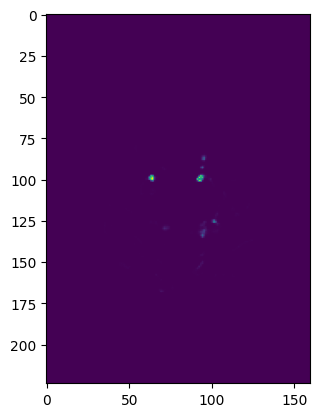

In [20]:
ent_maps[0].shape
plt.imshow(ent_maps[0][40])

#### best vd
I would like to say whether we can make say a deterministic policy, so we could go with what is the skew of the data for example. Nice.

In [21]:
vds = []
for m, y in zip(means, ys3d_test):
    vds.append(fast_vd(m.cuda().argmax(dim=1), y.cuda()))

In [22]:
%autoreload

In [23]:
_, sample_vds = per_sample_metric(samples, ys3d_test, f=fast_vd, do_argmax=True, do_softmax=False, minimise=True, take_abs=False)
sample_vd_skew = scipy.stats.skew(sample_vds, axis=1, bias=True)

chal_results['sample_vd_skew'] = sample_vd_skew
for s in range(sample_vds.shape[1]):
    chal_results[f'sample_{s}_vd'] = sample_vds[:,s]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.61it/s]


In [24]:
scipy.stats.skew(sample_vds, axis=1)

array([1.2447232 , 0.8808395 , 0.58777446, 0.58741945, 0.27889758,
       1.2617388 , 0.52344364, 0.16407624, 1.2901471 , 0.4213741 ,
       1.8549193 , 1.2554984 , 0.2531027 , 0.12305465, 0.28275523,
       0.9047476 , 0.21827538, 0.40160665, 0.21219267, 0.8510561 ,
       0.97141117, 0.9015454 , 0.7161618 , 0.6542103 , 0.69706917,
       0.6481604 , 0.64480346, 1.5291561 , 1.8575958 , 1.5443923 ,
       0.7584514 , 0.4083327 , 1.8326076 , 1.1904036 , 0.74639094,
       0.9281229 , 1.5705235 , 1.0845525 , 1.3185822 ], dtype=float32)

### GeD

In [310]:
def fast_iou(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = intersection.sum()
    denominator = p1.sum() + t1.sum() - numerator
    return (numerator/(denominator + 1e-30)).item()

In [319]:
def individual_multirater_iou_GED(mean, rater_ys, sample):
    ged = 0
    ys = [r for r in rater_ys]
    ss = sample.cuda().argmax(dim=2)
    num_samples = ss.shape[0]

    dists_ab = 0
    count_ab = 0
    for s in ss:
        for y in ys:
            pred = s#.argmax(dim=1)
            dists_ab += (1 - fast_iou(pred, y.cuda()))
            # print(dists_ab)
            # print(s.shape)
            count_ab += 1

    dists_ab /= count_ab # num_samples # count should be num_samples * num_raters for consistent number of raters but Ive just done this count for now.
    dists_ab *= 2

    dists_aa = 0
    count_aa = 0
    for j, y1 in enumerate(ys):
        for k, y2 in enumerate(ys):
            if j == k:
                continue
            dists_aa += (1 - fast_iou(y1.cuda(), y2.cuda()))
            count_aa += 1

    dists_aa /= count_aa

    dists_bb = 0
    for j, s1 in enumerate(ss):
        for k, s2 in enumerate(ss):
            if j == k:
                continue
            dists_bb += (1 - fast_iou(s1, s2))

    dists_bb /= (num_samples * (num_samples - 1))

    ged = dists_ab - dists_aa - dists_bb
        
    return ged

In [312]:
def multirater_iou_GED(means, rater_ys, samples):
    geds = []
    
    for i in tqdm(range(len(means)), position=0, leave=True):
        ys = [r[i] for r in rater_ys]
        ss = samples[i].cuda().argmax(dim=2)
        num_samples = ss.shape[0]
        
        dists_ab = 0
        count_ab = 0
        for s in ss:
            for y in ys:
                pred = s#.argmax(dim=1)
                dists_ab += (1 - fast_iou(pred, y.cuda()))
                # print(dists_ab)
                # print(s.shape)
                count_ab += 1
        
        dists_ab /= count_ab # num_samples # count should be num_samples * num_raters for consistent number of raters but Ive just done this count for now.
        dists_ab *= 2
        
        dists_aa = 0
        count_aa = 0
        for j, y1 in enumerate(ys):
            for k, y2 in enumerate(ys):
                if j == k:
                    continue
                dists_aa += (1 - fast_iou(y1.cuda(), y2.cuda()))
                count_aa += 1
        
        dists_aa /= count_aa
        
        dists_bb = 0
        for j, s1 in enumerate(ss):
            for k, s2 in enumerate(ss):
                if j == k:
                    continue
                dists_bb += (1 - fast_iou(s1, s2))
        
        dists_bb /= (num_samples * (num_samples - 1))
        
        ged = dists_ab - dists_aa - dists_bb
        if not np.isnan(ged):
            geds.append(ged)
        #break
        
    return torch.Tensor(geds)

In [26]:
def iou_GED(means, ys3d_test, samples):
    geds = []
    
    for i in tqdm(range(len(means)), position=0, leave=True):
        y = ys3d_test[i].cuda()
        ss = samples[i].cuda().argmax(dim=2)
        num_samples = ss.shape[0]
        
        dists_ab = 0
        
        # print(y.sum())
        
        for s in ss:
            pred = s#.argmax(dim=1)
            dists_ab += (1 - fast_iou(pred, y))
            # print(dists_ab)
            # print(s.shape)
        
        dists_ab /= num_samples
        dists_ab *= 2
        
        dists_ss = 0
        for j, s1 in enumerate(ss):
            for k, s2 in enumerate(ss):
                if j == k:
                    continue
                dists_ss += (1 - fast_iou(s1, s2))
        
        dists_ss /= (num_samples * (num_samples - 1))
        
        ged = dists_ab - dists_ss
        if not np.isnan(ged):
            geds.append(ged)
        #break
        
    return torch.Tensor(geds)

In [27]:
samples[0].shape

torch.Size([10, 48, 2, 224, 160])

In [28]:
geds = iou_GED(means, ys3d_test, samples)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00,  9.85it/s]


In [29]:
chal_results['GED^2'] = sample_top_dices

#### PAVPU (replace bras with pavpu)? 
actually BRAS is okay when all the methods are equally well calibrated?

In [30]:
means[0].shape, ent_maps[0].shape, ys3d_test[0].shape

(torch.Size([48, 2, 224, 160]),
 torch.Size([48, 224, 160]),
 torch.Size([48, 224, 160]))

In [31]:
def individual_pavpu(mean, ent_map, label, ws=4, acc_t=0.8):
    pred_unfolded = mean.argmax(dim=1).unfold(0, ws, ws).unfold(1, ws, ws).unfold(2, ws, ws).reshape(-1, ws, ws, ws)
    ent_unfolded = ent_map.unfold(0, ws, ws).unfold(1, ws, ws).unfold(2, ws, ws).reshape(-1, ws, ws, ws)
    ys_unfolded = label.unfold(0, ws, ws).unfold(1, ws, ws).unfold(2, ws, ws).reshape(-1, ws, ws, ws)

    patch_acc = (pred_unfolded == ys_unfolded).type(torch.float32).mean(dim=(1,2,3))
    patch_uncert = ent_unfolded.mean(dim=(1,2,3))
    patch_non_empty = ys_unfolded.sum(dim=(1,2,3)) > 0

    p_acc_cert = []
    p_uncert_inacc = []
    pavpu = []

    for tau in uncertainty_thresholds:
        acc = (patch_acc >= acc_t) * patch_non_empty
        inacc = (patch_acc < acc_t) * patch_non_empty
        cert = (patch_uncert < tau) * patch_non_empty
        uncert = (patch_uncert >= tau) * patch_non_empty

        n_ac = (acc * cert).sum().item()
        n_au = (acc * uncert).sum().item()
        n_iu = (inacc * uncert).sum().item()
        n_ic = (inacc * cert).sum().item()

        p_acc_cert.append(n_ac / (n_ac + n_ic + 1e-30))
        p_uncert_inacc.append(n_iu / (n_ic + n_iu + 1e-30))
        pavpu.append((n_ac + n_iu) / (n_ac + n_au + n_ic + n_iu + 1e-30))
        
    return p_acc_cert, p_uncert_inacc, pavpu

def all_individuals_pavpu(means, ent_maps, ys, window_size=4, accuracy_threshold=0.8):
    all_acc_cert = []
    all_uncert_inacc = []
    all_pavpu = []
    for i in tqdm(range(len(means)), position=0, leave=True):
        p_acc_cert, p_uncert_inacc, pavpu = individual_pavpu(means[i].cuda(), ent_maps[i].cuda(), ys[i].cuda(), window_size, accuracy_threshold)
        all_acc_cert.append(p_acc_cert)
        all_uncert_inacc.append(p_uncert_inacc)
        all_pavpu.append(pavpu)
        # break
    
    return torch.Tensor(all_acc_cert), torch.Tensor(all_uncert_inacc), torch.Tensor(all_pavpu)

In [32]:
all_acc_cert, all_uncert_inacc,all_pavpu = all_individuals_pavpu(means, ent_maps, ys3d_test, 4, 0.8)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 47.43it/s]


In [33]:
all_acc_cert.mean(dim=1).shape, uncertainty_thresholds.shape

(torch.Size([39]), torch.Size([70]))

In [34]:
all_acc_cert.shape

torch.Size([39, 70])

In [35]:
for i, tau in enumerate(uncertainty_thresholds):
    chal_results[f'p_acc_cert_{tau:.2f}'] = all_acc_cert[:,i]
    chal_results[f'p_uncert_inacc_{tau:.2f}'] = all_uncert_inacc[:,i]
    chal_results[f'pavpu_{tau:.2f}'] = all_pavpu[:,i]
    

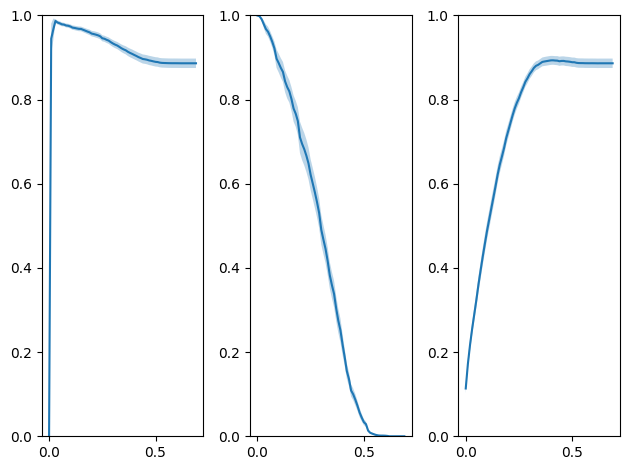

In [36]:
plt.subplot(1,3,1)
m = all_acc_cert.mean(dim=0)
plt.plot(uncertainty_thresholds, m)
si = all_acc_cert.std(dim=0)/(len(means)**0.5)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)
plt.ylim((0, 1))
plt.subplot(1,3,2)
m = all_uncert_inacc.mean(dim=0)
plt.plot(uncertainty_thresholds, m)
si = all_uncert_inacc.std(dim=0)/(len(means)**0.5)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)
plt.ylim((0, 1))
plt.subplot(1,3,3)
m = all_pavpu.mean(dim=0)
plt.plot(uncertainty_thresholds, m)
si = all_pavpu.std(dim=0)/(len(means)**0.5)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)
plt.ylim((0, 1))
plt.tight_layout()

#### bras unified score

In [ ]:
def filtered_dice(pred, ent_map, target, threshold):
    certain_locs = ent_map < threshold
    remaining_pred = pred[certain_locs]
    remaining_target = target[certain_locs]
    
    return fast_dice(remaining_pred, remaining_target)

def filtered_tps_score(pred, ent_map, target, threshold):
    total_tps = ((pred == 1) & (target == 1)).sum().item()
    uncertain_locs = ent_map < threshold
    
    filtered_tps = ((pred[uncertain_locs] == 1) & (target[uncertain_locs] == 1)).sum().item()
    
    return (total_tps - filtered_tps) / (total_tps + 1e-30)

def filtered_tns_score(mask, pred, ent_map, target, threshold):
    mask = mask.type(torch.bool)
    pred = pred[mask]
    ent_map = ent_map[mask]
    target = target[mask]
    
    total_tns = ((pred == 0) & (target == 0)).sum().item()
    uncertain_locs = ent_map < threshold
    
    filtered_tns = ((pred[uncertain_locs] == 0) & (target[uncertain_locs] == 0)).sum().item()
    
    return (total_tns - filtered_tns) / (total_tns + 1e-30)

#### sUEO score, UEO per threshold, max UEO?

I need to filter out bad predictions (broken images) in the visualisation of results section.

In [37]:
def sUEO(pred, ent_map, target):
    errors = (pred != target)
    
    numerator = 2 * (ent_map * errors).sum()
    denominator = (errors**2).sum() + (ent_map**2).sum()
    
    return (numerator / denominator).item()

In [38]:
def get_sUEOs(means, ys3d_test, ent_maps):
    sUEOs = []
    for i in tqdm(range(len(ent_maps)), position=0, leave=True):
        pred = means[i].argmax(dim=1).cuda()
        target = ys3d_test[i].cuda()
        ent = ent_maps[i].cuda()

        if pred.sum() == 0:
            continue

        sUEOs.append(sUEO(pred, ent, target))

    sUEOs = torch.Tensor(sUEOs)
    return sUEOs

In [39]:
sUEOs = get_sUEOs(means, ys3d_test, ent_maps)
chal_results['sUEO'] = sUEOs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.43it/s]


In [40]:
def UEO_per_threshold_analysis(uncertainty_thresholds, ys3d, ind_ent_maps, means, max_ent):
    ueos = [[] for _ in range(len(uncertainty_thresholds))]
                              
    for i in tqdm(range(len(ys3d)), position=0, leave=True):
        pred = means[i].argmax(dim=1).cuda()
        target = ys3d[i].cuda()
        ent = ind_ent_maps[i].cuda()
        
        # if pred.sum() == 0:
        #     continue
        
        for j, t in enumerate((uncertainty_thresholds)):
            ueos[j].append(sUEO(pred, (ent > t).type(torch.float32), target))
    
    ueos = torch.stack([torch.Tensor(ind_ueo) for ind_ueo in ueos], dim=0)
#     ueos_mean = ueos.mean(dim=1)
#     ueos_std = ueos.std(dim=1)

#     best_index = torch.Tensor(ueos).argmax()
#     return ueos_mean, ueos_std
    return ueos

In [41]:
ueos = UEO_per_threshold_analysis(uncertainty_thresholds, ys3d_test, ent_maps, means, 0.7)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.78it/s]


In [42]:
ueos_mean = ueos.mean(dim=1)
ueos_std = ueos.std(dim=1)

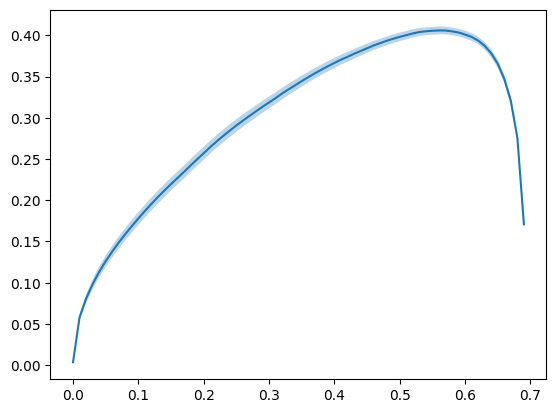

In [43]:
plt.plot(uncertainty_thresholds, ueos_mean)
sn = len(ueos_mean) ** 0.5
plt.fill_between(uncertainty_thresholds, ueos_mean - ueos_std/sn, ueos_mean + ueos_std/sn, alpha=0.3)


In [44]:
for i, tau in enumerate(uncertainty_thresholds):
    chal_results[f'UEO_{tau:.2f}'] = ueos[i]

### 2D connected components analysis

In [147]:
def conn_comp_2d_analysis(uncertainty_thresholds, ys3d, means3d, ind_ent_maps):
    conncomp_outs = []

    for y in tqdm(ys3d, position=0, leave=True, ncols=150):
        labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
        conncomp_outs.append(labels_out)

    # this is the 1 pixel is covered by the entropy
    #c_thresholds = [0.05, 0.1, 0.2, 0.3, 0.6]
    c_thresholds = [t.item() for t in uncertainty_thresholds]
    coverages = [0.1, 0.5, 0.9]
    missing_lesion_size_ent = []
    existing_lesion_size_ent = []

    missing_lesion_size_mean = []

    num_entirely_missed_lesions = {ct:0 for ct in c_thresholds}
    entirely_missed_lesions_size = {ct:[] for ct in c_thresholds}
    proportion_missing_lesion_covered_ent = {ct:[] for ct in c_thresholds}
    num_lesions = 0
    sizes = []
    missing_area_sizes = []
    missing_area_coverage = {ct:[] for ct in c_thresholds}
    for batch in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
        for i in range(0, ys3d[batch].shape[0], 3):
            conncomps = conncomp_outs[batch][i]
            ent = ind_ent_maps[batch][i]
            mean = means3d[batch].argmax(dim=1)[i]

            ids = conncomps.unique()[1:]
            for idx in ids:
                cc = (conncomps == idx)
                num_lesions += 1
                size = torch.sum(cc)
                sizes.append(size)

                missing_area = (mean == 0) & cc
                ma_size = missing_area.sum()
                missing_area_sizes.append(ma_size)

                # get uncertain pixels for each threshold
                for tau in c_thresholds:
                    uncert = (ent > tau).type(torch.long)

                    # coverage proportion
                    coverage = (uncert * missing_area).sum() / ma_size
                    missing_area_coverage[tau].append(coverage)


                    if torch.max(mean * cc) == 0:
                        # proportion of those lesions that are missing from mean covered by uncertainty
                        proportion_missing_lesion_covered_ent[tau].append(torch.sum(uncert * cc) / size)

                        # lesions entirely missed by both mean prediction and uncertainty map
                        # i.e not a single voxel is identified as uncertain or mean, total silent failure.
                        if torch.max(uncert * cc) == 0:
                            num_entirely_missed_lesions[tau] += 1
                            entirely_missed_lesions_size[tau].append(size)

    # replace nans and convert to tensor
    for tau in c_thresholds:
        missing_area_coverage[tau] = torch.Tensor([c.item() if not torch.isnan(c) else 0 for c in missing_area_coverage[tau]])
    
    mean_missed_area = torch.Tensor([missing_area_coverage[tau].mean().item() for tau in c_thresholds])
    mean_size_missed_lesions = torch.Tensor([torch.Tensor(entirely_missed_lesions_size[tau]).mean().item() for tau in c_thresholds])
    mean_cov_mean_missed_lesions = torch.Tensor([torch.Tensor(proportion_missing_lesion_covered_ent[tau]).mean().item() for tau in c_thresholds])
    num_missed_lesions = torch.Tensor([num_entirely_missed_lesions[tau] for tau in c_thresholds])
    prop_lesions_missed = torch.Tensor([num_entirely_missed_lesions[tau]/num_lesions for tau in c_thresholds])

    return mean_missed_area, mean_size_missed_lesions, mean_cov_mean_missed_lesions, num_missed_lesions, prop_lesions_missed, num_lesions



In [148]:
mean_missed_area, mean_size_missed_lesions, mean_cov_mean_missed_lesions, num_missed_lesions, prop_lesions_missed, num_lesions = conn_comp_2d_analysis(uncertainty_thresholds, ys3d_test, means, ent_maps)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:30<00:00,  3.85s/it]


#### 3D connected components analysis

In [231]:
import cc3d

def get_3d_cc_analysis(img, mean, ent, uncertainty_thresholds, ss=5, prop_size=0.5):
    mean = mean.argmax(dim=1).cuda()
    ent = ent.cuda()
    labels_in = img.cpu()
    labels_out = cc3d.connected_components(img.type(torch.int32).numpy(), connectivity=26) # 26-connected
    labels_out = torch.from_numpy(labels_out.astype(np.float32)).cuda()
    
    c_thresholds = [t.item() for t in uncertainty_thresholds]

    num_lesions = labels_out.unique().shape[0] - 1
    sizes = []
    missing_area_sizes = []
    missing_area_coverage = {ct:[] for ct in c_thresholds}
    proportion_missing_lesion_covered_ent = {ct:[] for ct in c_thresholds}
    num_entirely_missed_lesions = {ct:0 for ct in c_thresholds}
    entirely_missed_lesions_size = {ct:[] for ct in c_thresholds}

    for ccid in labels_out.unique():
        if ccid == 0:
            continue

        cc = labels_out == ccid
        size = cc.sum().item()
        sizes.append(size)

        missing_area = (mean == 0) & cc
        ma_size = missing_area.sum()
        # print(ma_size)
        missing_area_sizes.append(ma_size)

        # get uncertain pixels for each threshold
        for tau in c_thresholds:
            uncert = (ent > tau).type(torch.long)

            # coverage proportion
            coverage = (uncert * missing_area).sum() / (ma_size + 1e-30)
            missing_area_coverage[tau].append(coverage)


            ss = 5
            prop_ss = 0.5
            if torch.sum(mean * cc) <= min(size * prop_ss, ss): # (size * prop_ss):
                # proportion of those lesions that are missing from mean covered by uncertainty
                proportion_missing_lesion_covered_ent[tau].append(torch.sum(uncert * cc) / size)

                # lesions entirely missed by both mean prediction and uncertainty map
                # i.e not a single voxel is identified as uncertain or mean, total silent failure.
                if torch.sum(uncert * cc) <= min(size * prop_ss, ss): # (size * prop_ss):
                    num_entirely_missed_lesions[tau] += 1
                    entirely_missed_lesions_size[tau].append(size)

    mean_missed_area3d = torch.Tensor([torch.Tensor(missing_area_coverage[tau]).mean().item() for tau in c_thresholds])
    mean_size_missed_lesions3d = torch.Tensor([torch.Tensor(entirely_missed_lesions_size[tau]).mean().item() for tau in c_thresholds])
    mean_cov_mean_missed_lesions3d = torch.Tensor([torch.Tensor(proportion_missing_lesion_covered_ent[tau]).mean().item() for tau in c_thresholds])
    # num_missed_lesions3d = torch.Tensor([num_entirely_missed_lesions[tau] for tau in c_thresholds])
    prop_lesions_missed3d = torch.Tensor([num_entirely_missed_lesions[tau]/num_lesions for tau in c_thresholds])

    return num_lesions, sizes, mean_missed_area3d, mean_size_missed_lesions3d, mean_cov_mean_missed_lesions3d, prop_lesions_missed3d
    

num_lesions_all, sizes_all, mean_missed_area3d_all, mean_size_missed_lesions3d_all, mean_cov_mean_missed_lesions3d_all, prop_lesions_missed3d_all = [], [], [], [], [], []
for i in tqdm(range(len(means)), position=0, leave=True):
    num_lesions, sizes, mean_missed_area3d, mean_size_missed_lesions3d, mean_cov_mean_missed_lesions3d, prop_lesions_missed3d = get_3d_cc_analysis(ys3d_test[i], means[i], ent_maps[i], uncertainty_thresholds)
    num_lesions_all.append(num_lesions)
    sizes_all.append(sizes)
    mean_missed_area3d_all.append(mean_missed_area3d)
    mean_size_missed_lesions3d_all.append(mean_size_missed_lesions3d)
    mean_cov_mean_missed_lesions3d_all.append(mean_cov_mean_missed_lesions3d)
    prop_lesions_missed3d_all.append(prop_lesions_missed3d)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:25<00:00,  3.73s/it]


In [241]:
for i, tau in enumerate(uncertainty_thresholds):
    chal_results[f'mean_missed_area3d_all_{tau:.2f}'] = torch.stack(mean_missed_area3d_all)[:,i]
    chal_results[f'mean_cov_mean_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_cov_mean_missed_lesions3d_all)[:,i]
    chal_results[f'mean_size_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_size_missed_lesions3d_all)[:,i]
    chal_results[f'prop_lesions_missed3d_all_{tau:.2f}'] = torch.stack(prop_lesions_missed3d_all)[:,i]

In [235]:
pm = torch.stack(prop_lesions_missed3d_all)

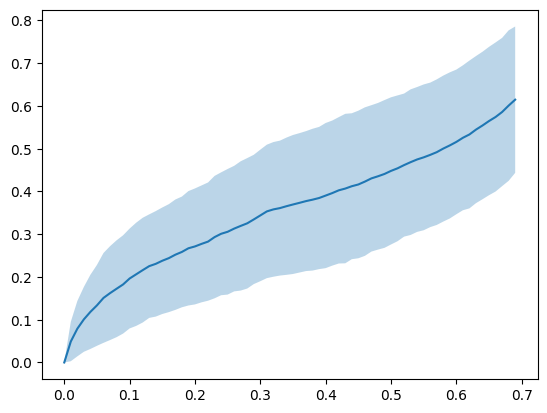

In [239]:
m = pm.mean(dim=0)
si = pm.std(dim=0)
plt.plot(uncertainty_thresholds, m)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)

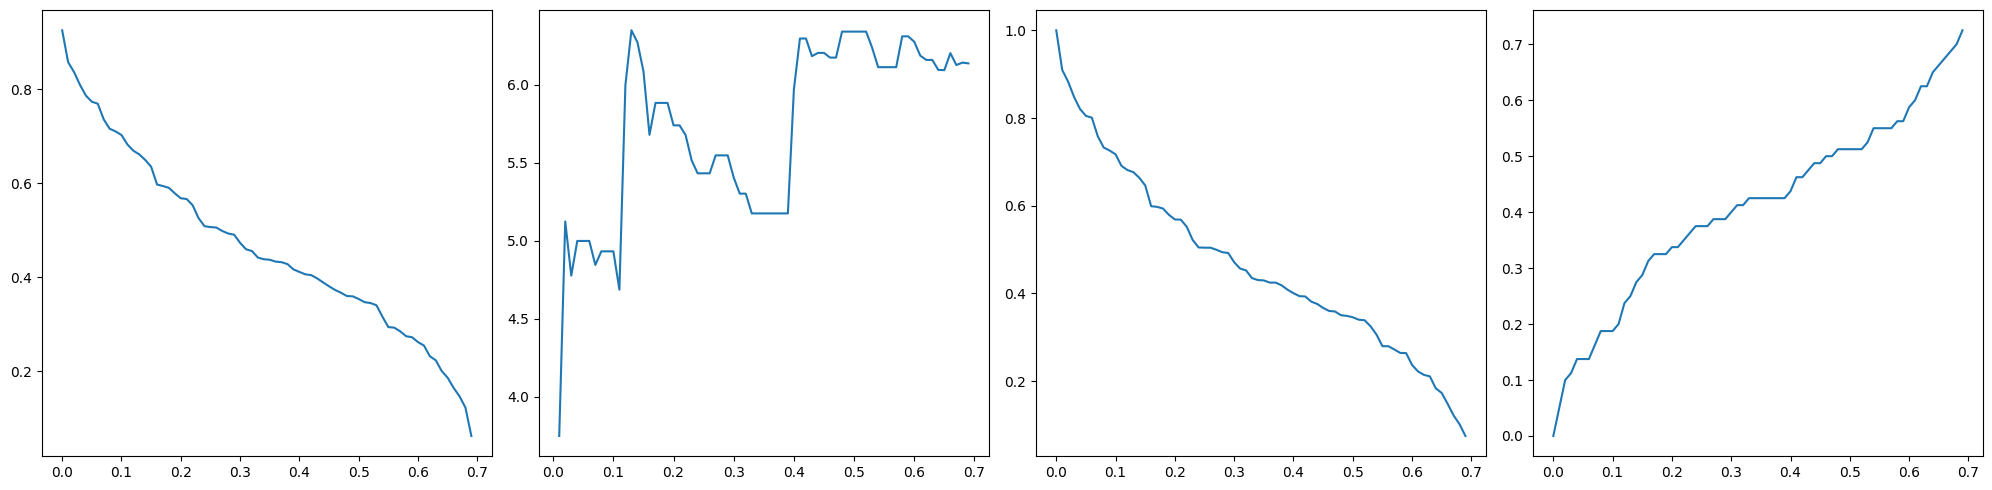

In [219]:
plt.figure(figsize=(25, 5))
plt.subplot(1,5,1)
plt.plot(uncertainty_thresholds, mean_missed_area3d)
plt.subplot(1,5,2)
plt.plot(uncertainty_thresholds, mean_size_missed_lesions3d)
plt.subplot(1,5,3)
plt.plot(uncertainty_thresholds, mean_cov_mean_missed_lesions3d)
plt.subplot(1,5,4)
plt.plot(uncertainty_thresholds, prop_lesions_missed3d)
plt.tight_layout()

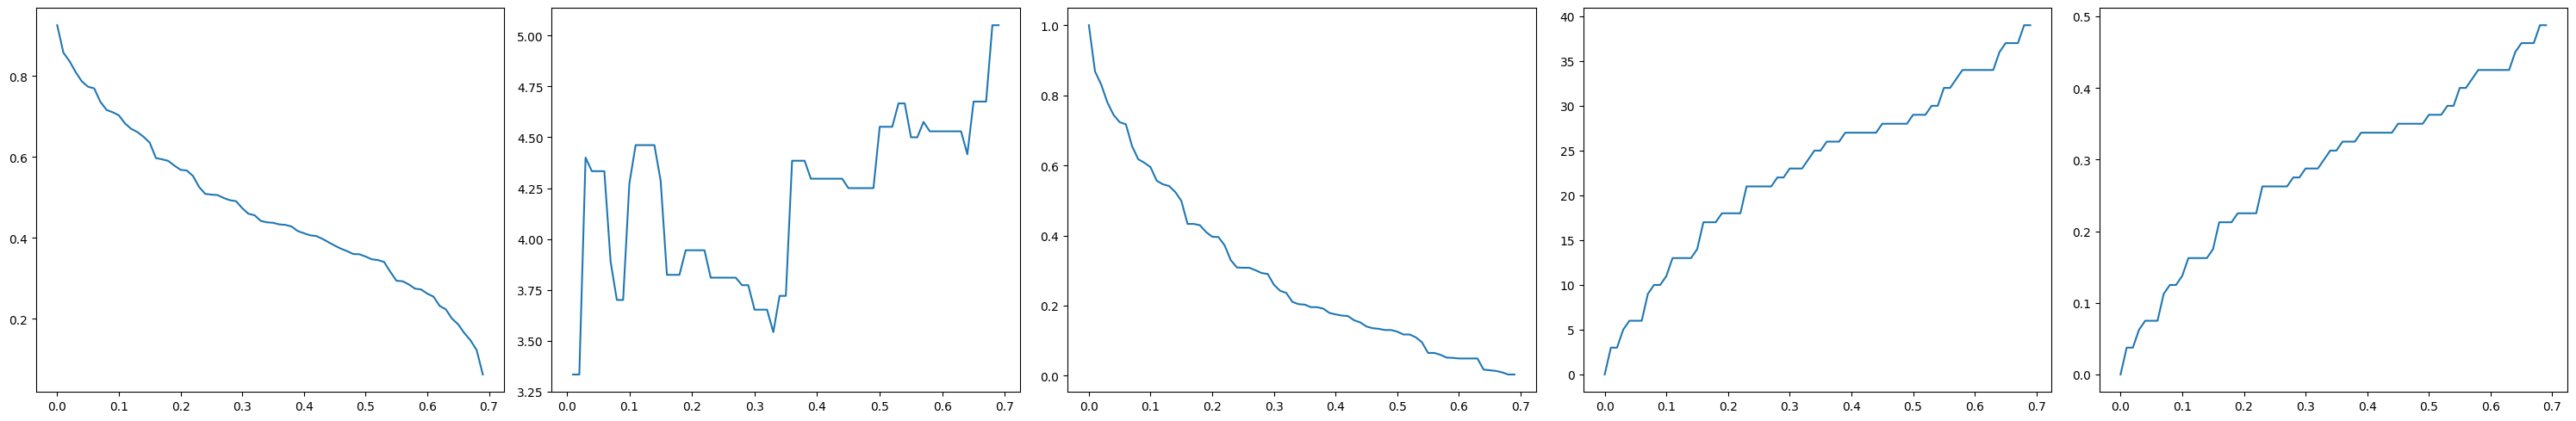

In [174]:
plt.figure(figsize=(30, 5))
plt.subplot(1,5,1)
plt.plot(uncertainty_thresholds, mean_missed_area3d)
plt.subplot(1,5,2)
plt.plot(uncertainty_thresholds, mean_size_missed_lesions3d)
plt.subplot(1,5,3)
plt.plot(uncertainty_thresholds, mean_cov_mean_missed_lesions3d)
plt.subplot(1,5,4)
plt.plot(uncertainty_thresholds, num_missed_lesions3d)
plt.subplot(1,5,5)
plt.plot(uncertainty_thresholds, prop_lesions_missed3d)
plt.tight_layout()

#### calibration

#### best sample metrics as we increase the number of samples
need to collect best dice, DGed, best rmse, mean sample rmse, best avd and best vd as we increase number of samples..... Also store something like uoe score and mean dice for ensemble, to see how well it generalizes as the sample size increases).
The way to do this is to collect the 10 or 60 samples whatever and then do the ordering each time for a new set of the samples. Then recompute the metrics each time and record the best dice for each individual, so best dice at 1, 2, 3 n samples etc. Love it, great.
How we will do 60 samples or 10 samples for the ensemble depending on the dataset needs to be worked through. Good stuff though. Love it.

### saving the results

In [52]:
# save the results
write_per_model_channel_stats(preds=None, ys3d_test=None, args=args, chal_results=chal_results)